<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/6_Custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resource  
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb  
https://www.learnpytorch.io/04_pytorch_custom_datasets/


# 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.3.0+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Download data
data_source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    response = requests.get(data_source)
    print("Downloading pizza, steak, sushi data...")
    f.write(response.content)

# Unzip the downloaded file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# 2. Become one with the data (data preparation)

In [ ]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2.1 Visualize an image

Random image path: data/pizza_steak_sushi/train/sushi/170385.jpg
Image class: sushi
Image height: 382
Image width: 512


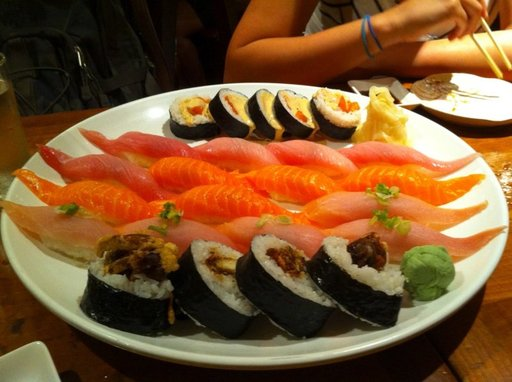

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

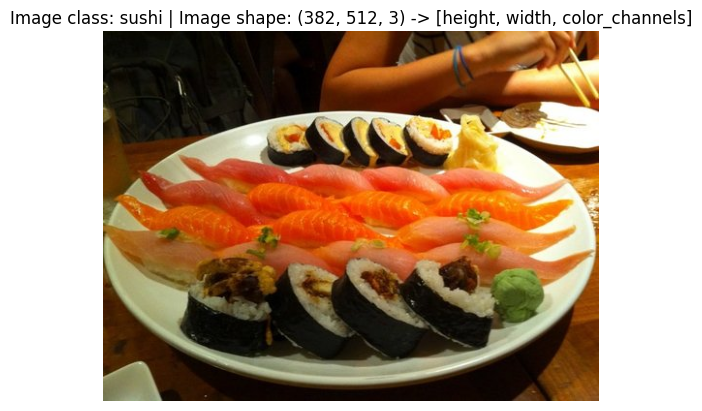

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.array(img))
plt.title(f"Image class: {image_class} | Image shape: {np.array(img).shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()

# 3. Transforming data

tensor>dataset>dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

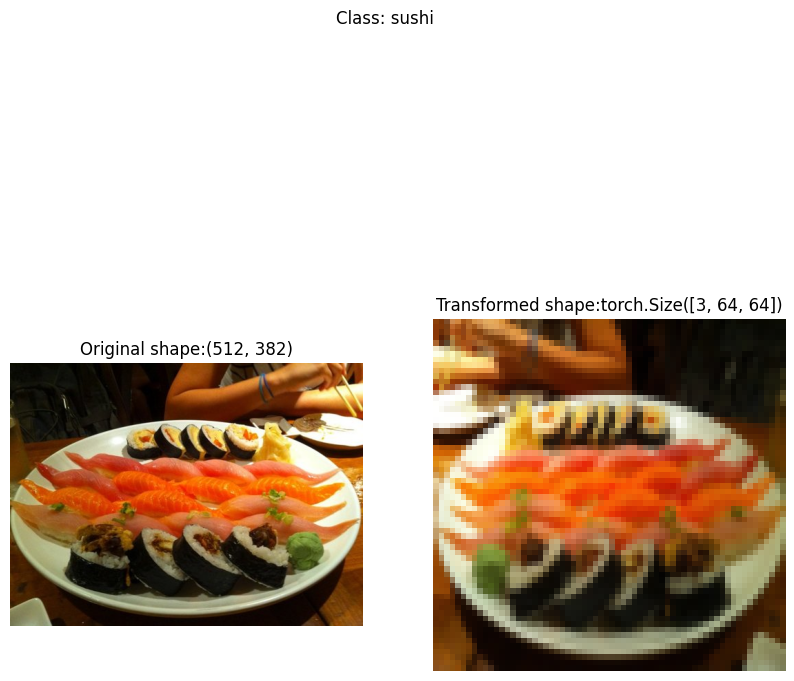

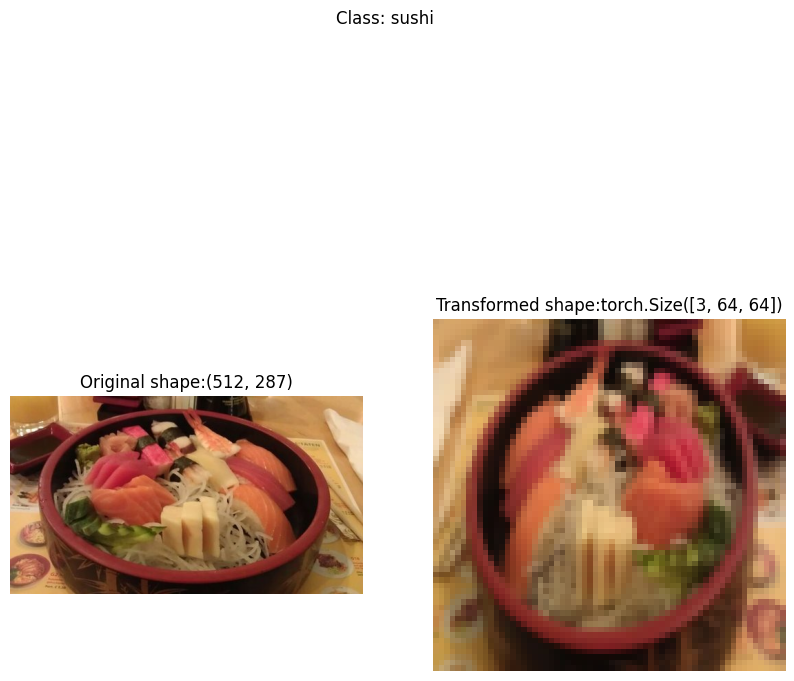

In [ ]:
def plot_transformed_image(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, n)

    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 10))
            axes[0].imshow(img)
            axes[0].set_title(f"Original shape:{img.size}")
            axes[0].axis("off")

            transformed_image = transform(img)
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            axes[1].imshow(transformed_image.permute(1, 2, 0))
            axes[1].set_title(f"Transformed shape:{transformed_image.shape}")
            axes[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}")
            plt.show()

plot_transformed_image(image_path_list, data_transform, 2, 42)


# 4. Option 1: Loading Image Data Using ImageFolder

In [ ]:
from torchvision import datasets, transforms

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(train_dataset, test_dataset)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
class_names = train_dataset.classes

In [ ]:
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_dataset)

225

In [ ]:
train_dataset.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
img, label = train_dataset[0][0], train_dataset[0][1]
img, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

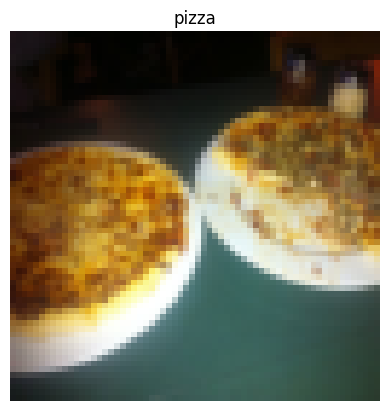

In [ ]:
img_permute = img.permute(1, 2, 0)

plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label])
plt.show()

# 4.1 Turn loaded images into DataLoader's

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f259198af80>,
 <torch.utils.data.dataloader.DataLoader at 0x7f259198b6d0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [ ]:
img, label = next(iter(train_dataloader))
img, label

(tensor([[[[0.9804, 0.9843, 0.9922,  ..., 0.9765, 0.9725, 0.9804],
           [0.9882, 0.9922, 0.9882,  ..., 0.9804, 0.9804, 0.9804],
           [0.9765, 0.9765, 0.9765,  ..., 0.9804, 0.9765, 0.9765],
           ...,
           [0.9686, 0.9725, 0.9725,  ..., 0.9529, 0.9647, 0.9647],
           [0.9686, 0.9725, 0.9725,  ..., 0.9569, 0.9686, 0.9686],
           [0.9725, 0.9765, 0.9725,  ..., 0.9608, 0.9725, 0.9765]],
 
          [[0.9529, 0.9725, 0.9922,  ..., 0.9412, 0.9373, 0.9451],
           [0.9686, 0.9882, 0.9961,  ..., 0.9294, 0.9294, 0.9294],
           [0.9137, 0.9412, 0.9608,  ..., 0.9216, 0.9216, 0.9176],
           ...,
           [0.8627, 0.8667, 0.8667,  ..., 0.8353, 0.8588, 0.8667],
           [0.8667, 0.8667, 0.8745,  ..., 0.8510, 0.8706, 0.8745],
           [0.8667, 0.8706, 0.8706,  ..., 0.8588, 0.8784, 0.8824]],
 
          [[0.7765, 0.8353, 0.9412,  ..., 0.8471, 0.8549, 0.8667],
           [0.8157, 0.8824, 0.9569,  ..., 0.8118, 0.8118, 0.8078],
           [0.6824, 0.72

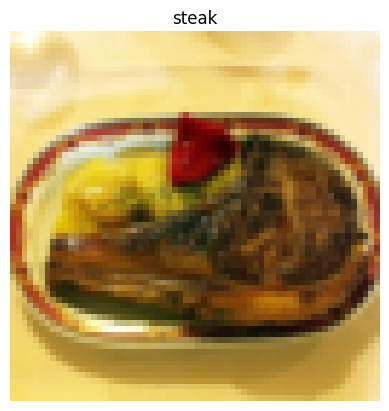

In [ ]:
img_permute = img[0].permute(1, 2, 0)

plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label[0]])
plt.show()

# 5. Option 2: Loading Image Data with a Custom Dataset

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
train_dataset.classes, train_dataset.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# 5.1 Creating a helper function to get class names

In [ ]:
target_dir = train_dir
print(target_dir)

class_names_found = sorted([name.name for name in pathlib.Path(target_dir).iterdir() if name.is_dir()])
print(class_names_found)

data/pizza_steak_sushi/train
['pizza', 'steak', 'sushi']


In [ ]:
def find_classes(directory):
    classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()])
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# 5.2 Create a custom Dataset to replicate ImageFolder

1.Subclass torch.utils.data.Dataset.  

2.Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).  

3.Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).  

4.Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).  

5.Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).  

6.Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [ ]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_image(self, idx):
        image = Image.open(self.paths[idx])
        return image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.class_to_idx[self.paths[idx].parent.name]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from torchvision import transforms

train_transform_custom = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform_custom = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = CustomImageDataset(target_dir=train_dir, transform=train_transform_custom)
test_data_custom = CustomImageDataset(target_dir=test_dir, transform=test_transform_custom)

In [ ]:
len(train_data_custom), train_data_custom.classes, train_data_custom.class_to_idx

(225, ['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
print(train_data_custom.classes == train_dataset.classes)
print(test_data_custom.classes == test_dataset.classes)

True
True


# 5.3 Create a function to display random images

In [ ]:
def display_random_images(dataset, classes=None, n=3, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape=False
        print(f"For display, purpose, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(20, 10))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adj = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adj)
        plt.axis(False)
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adj.shape}"
        plt.title(title, fontsize=10)

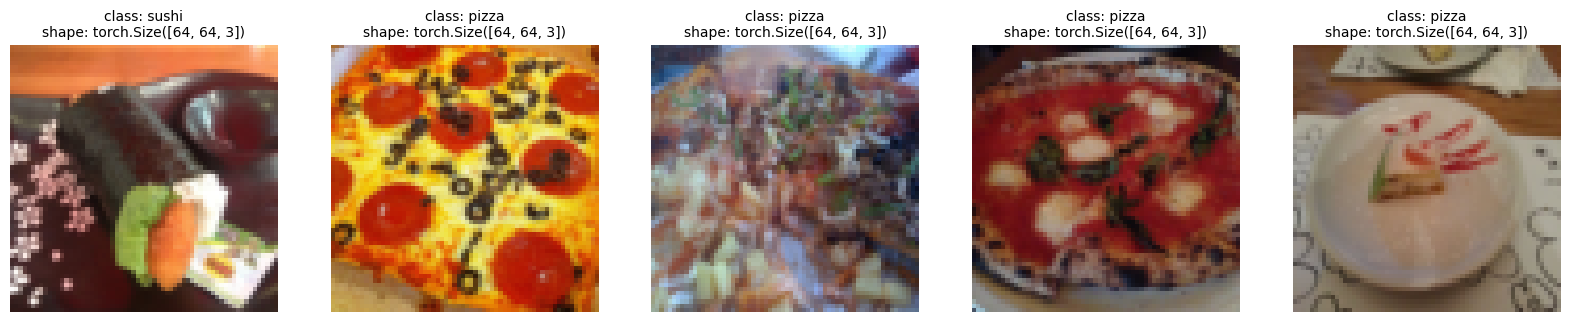

In [ ]:
display_random_images(train_dataset, classes=class_names,
                      n=5, seed=None)

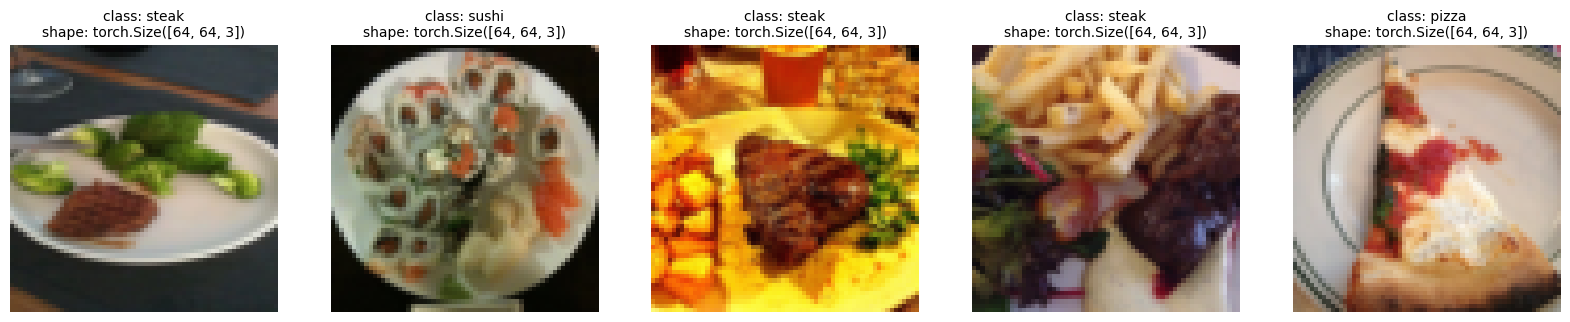

In [ ]:
display_random_images(train_data_custom, classes=class_names,
                      n=5, seed=None)

# 5.4 Turn custom loaded images into DataLoader's

In [ ]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=32, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=32, shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f259186ae60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f259186abf0>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom, label_custom

(tensor([[[[0.6627, 0.6431, 0.6235,  ..., 0.7843, 0.6078, 0.5725],
           [0.6863, 0.7216, 0.7882,  ..., 0.7098, 0.5176, 0.5373],
           [0.7098, 0.7843, 0.7882,  ..., 0.7059, 0.4588, 0.4667],
           ...,
           [0.7804, 0.7725, 0.7765,  ..., 0.7098, 0.7137, 0.7020],
           [0.7804, 0.7647, 0.7490,  ..., 0.6902, 0.6824, 0.6824],
           [0.7725, 0.7765, 0.7451,  ..., 0.6627, 0.6431, 0.6784]],
 
          [[0.4235, 0.4196, 0.4549,  ..., 0.5020, 0.2784, 0.2275],
           [0.5490, 0.6471, 0.7686,  ..., 0.4314, 0.1961, 0.2078],
           [0.6667, 0.7961, 0.8157,  ..., 0.4235, 0.1608, 0.1451],
           ...,
           [0.6549, 0.6510, 0.6588,  ..., 0.2471, 0.4118, 0.4980],
           [0.6745, 0.6392, 0.6000,  ..., 0.2549, 0.4157, 0.4667],
           [0.6471, 0.6745, 0.6275,  ..., 0.2510, 0.3804, 0.4706]],
 
          [[0.1647, 0.2196, 0.3686,  ..., 0.1412, 0.0510, 0.0275],
           [0.4353, 0.6275, 0.8157,  ..., 0.1373, 0.0275, 0.0314],
           [0.6745, 0.85

# 6. Other forms of transforms (data augmentation)

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/542188.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2021381.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1575445.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1232045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/424994.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2323548.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/17704.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2120573.jpg')]

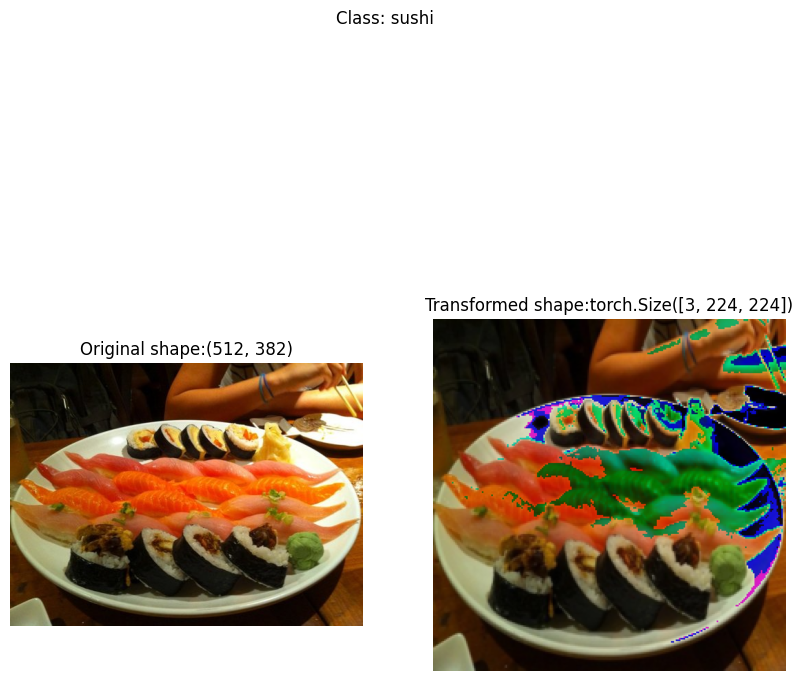

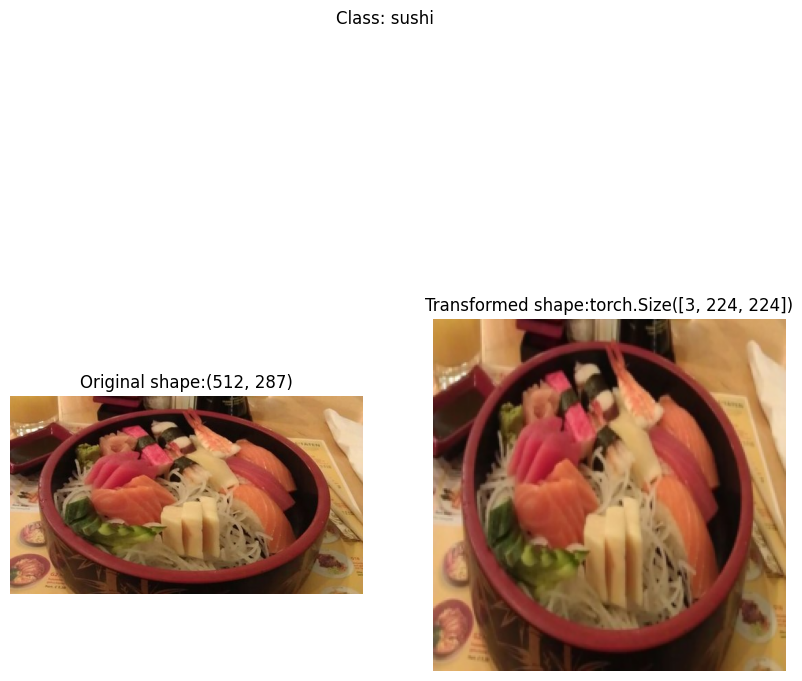

In [ ]:
plot_transformed_image(image_path_list, train_transform, 2, 42)

# 7. Model 0: TinyVGG without data augmentation

# 7.1 Creating transforms and loading data for Model 0

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets, transforms
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List

train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=32, shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=32, shuffle=False)

# 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 256,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

# 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

# 7.4 Use torchinfo to get an idea of the shapes going through our model

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

# 7.5 Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        if batch % 100 == 0:
            print(f"Train loss: {train_loss / len(dataloader):.5f} | Train accuracy: {train_acc / len(dataloader):.2f}%")
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            if batch % 100 == 0:
                print(f"Test loss: {test_loss / len(dataloader):.5f} | Test accuracy: {test_acc / len(dataloader):.2f}%")
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

# 7.6 Creating a train() function to combine train_step() and test_step()

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device):

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


# 7.7 Train and Evaluate Model 0

In [ ]:
results_model0 = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer=torch.optim.Adam(params=model_0.parameters()), loss_fn=nn.CrossEntropyLoss(), epochs=5, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.13746 | Train accuracy: 0.04%
Test loss: 0.34821 | Test accuracy: 0.26%
Epoch: 1 | Train loss: 1.1000 | Train acc: 0.4023 | Test loss: 1.1026 | Test acc: 0.2604
Train loss: 0.13648 | Train accuracy: 0.05%
Test loss: 0.30272 | Test accuracy: 0.26%
Epoch: 2 | Train loss: 1.0843 | Train acc: 0.4258 | Test loss: 1.1687 | Test acc: 0.2604
Train loss: 0.14168 | Train accuracy: 0.04%
Test loss: 0.31199 | Test accuracy: 0.26%
Epoch: 3 | Train loss: 1.1324 | Train acc: 0.3047 | Test loss: 1.1566 | Test acc: 0.2604
Train loss: 0.13704 | Train accuracy: 0.05%
Test loss: 0.34306 | Test accuracy: 0.26%
Epoch: 4 | Train loss: 1.0932 | Train acc: 0.4258 | Test loss: 1.1381 | Test acc: 0.2604
Train loss: 0.13764 | Train accuracy: 0.04%
Test loss: 0.34170 | Test accuracy: 0.26%
Epoch: 5 | Train loss: 1.0913 | Train acc: 0.4258 | Test loss: 1.1433 | Test acc: 0.2604


# 7.8 Plot the loss curves of Model 0

In [ ]:
 import matplotlib.pyplot as plt

 def plot_loss_curves(results):
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="train_loss")
    plt.plot(results["test_loss"], label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label="train_acc")
    plt.plot(results["test_acc"], label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

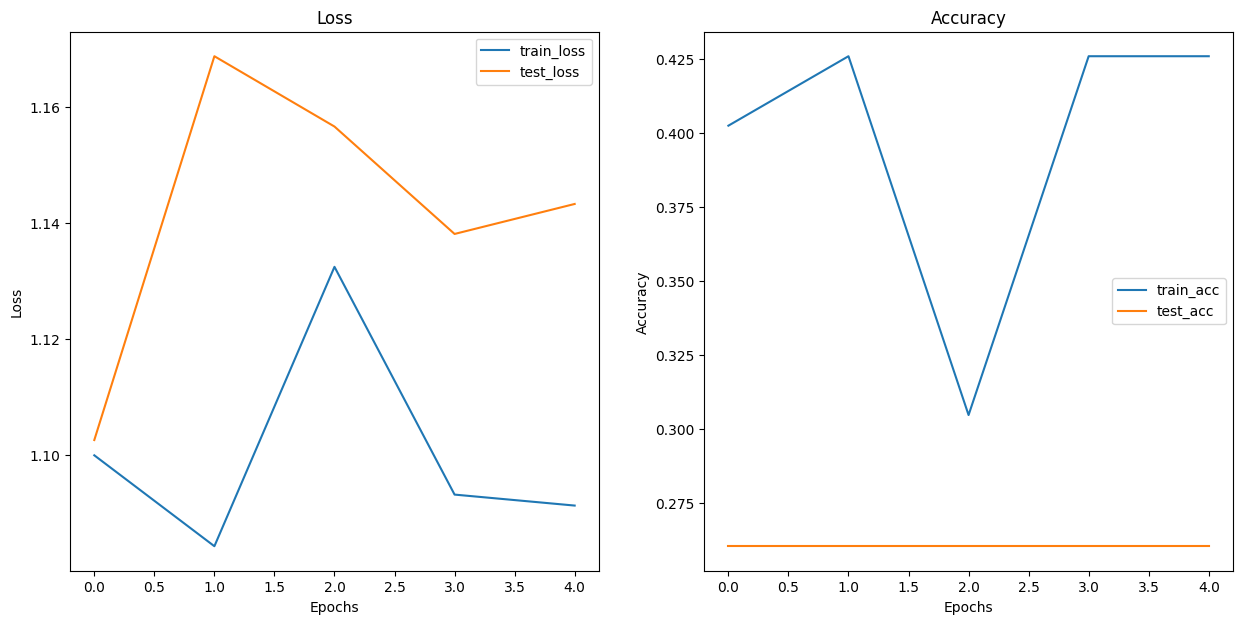

In [ ]:
plot_loss_curves(results_model0)

# 8. What should an ideal loss curve look like?
 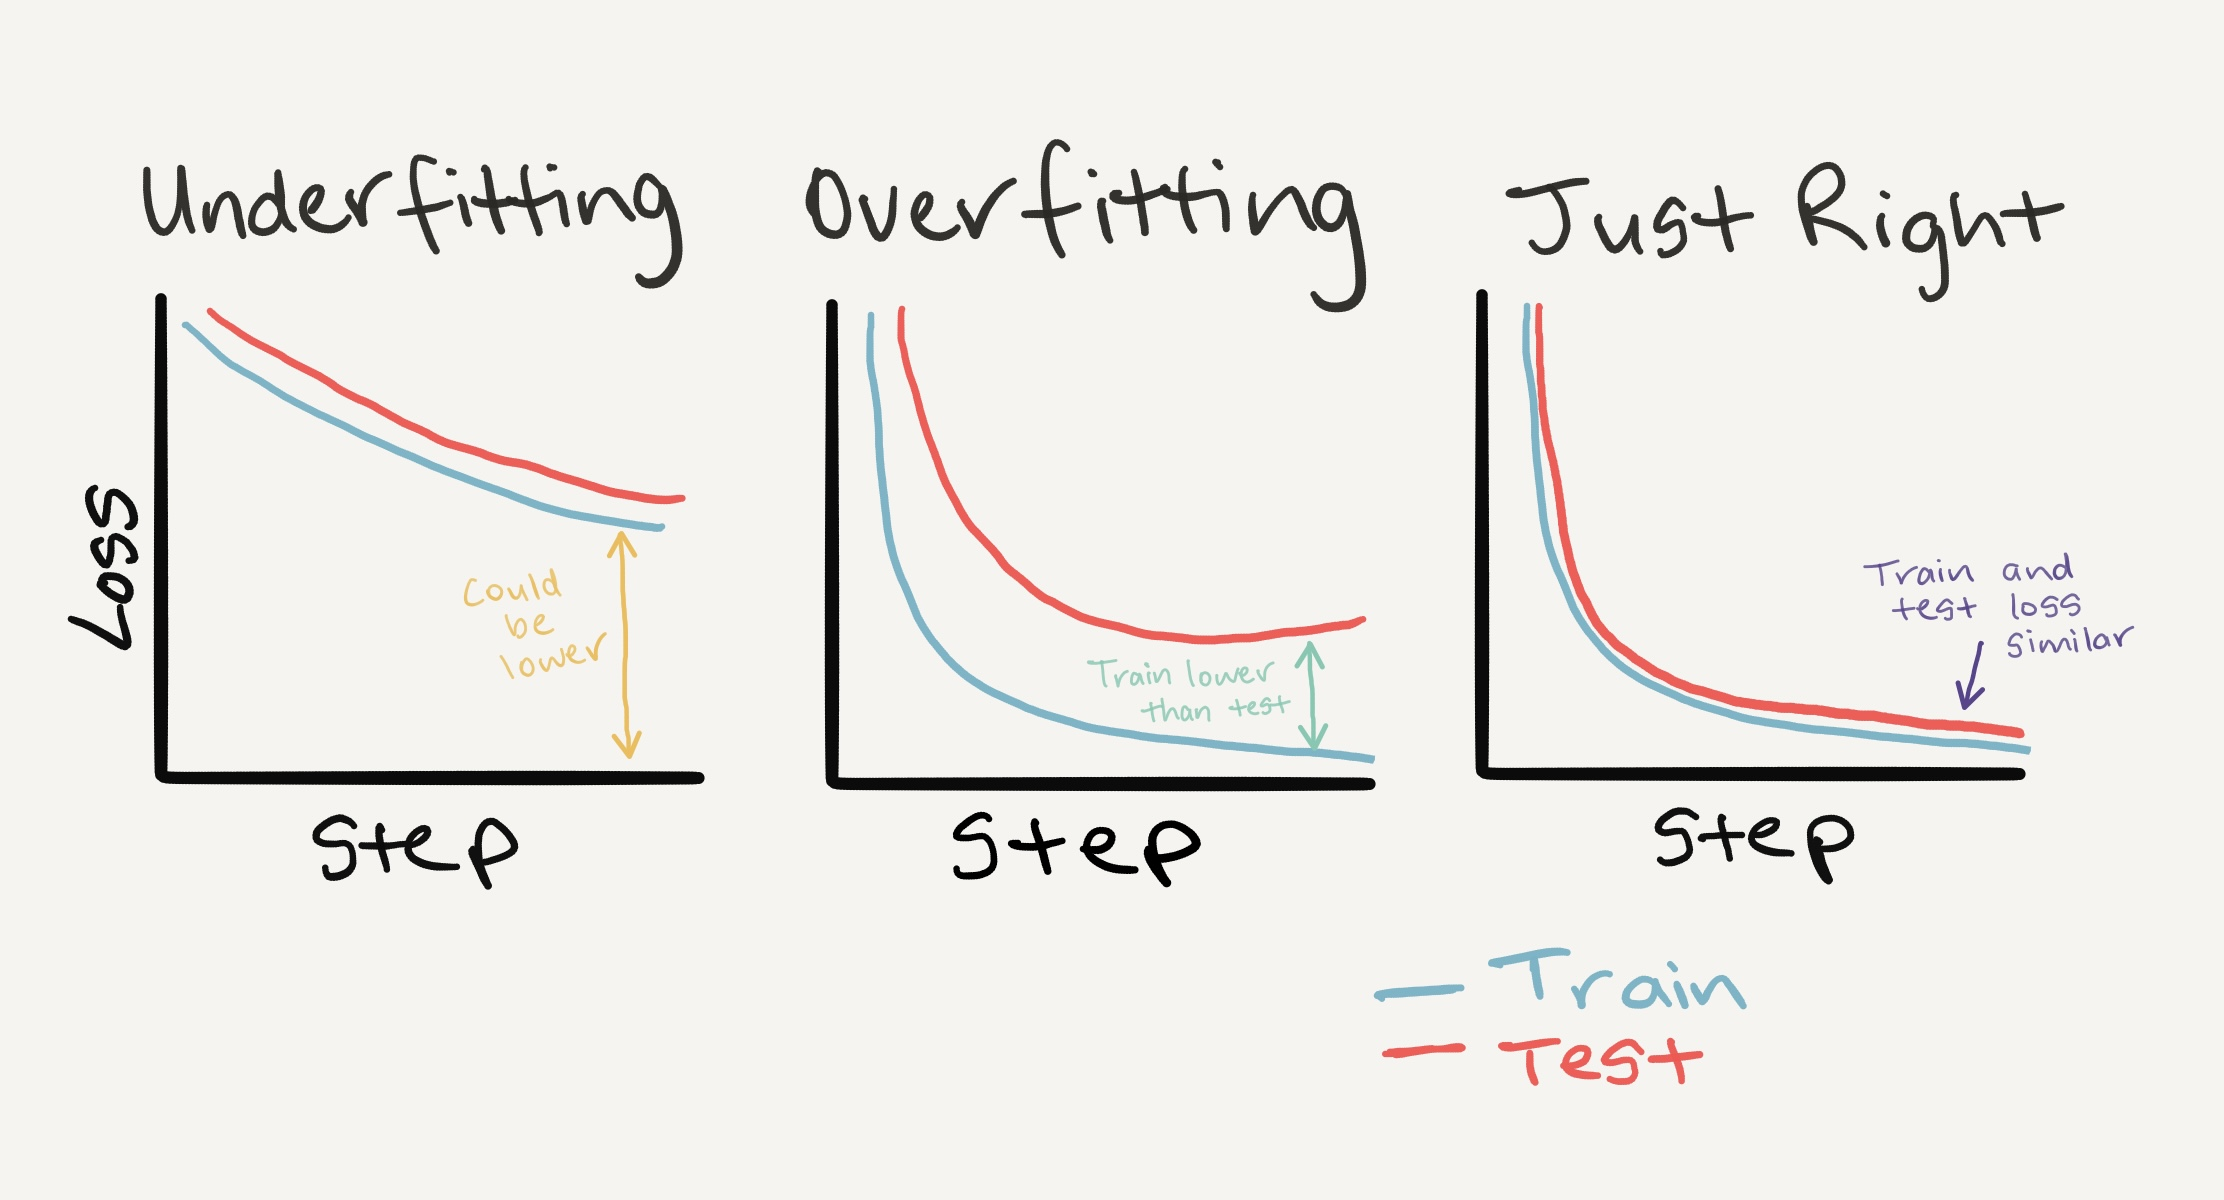

# 9. Model 1: TinyVGG with Data Augmentation

# 9.1 Create transform with data augmentation

In [ ]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# 9.2 Create train and test Dataset's and DataLoader's

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets

train_data_argumented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform_trivial)

In [ ]:
import os

train_dataloader_argumented = DataLoader(train_data_argumented, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# 9.3 Construct and train Model 1

In [ ]:
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
results_model1 = train(model_1, train_dataloader_argumented, test_dataloader, optimizer=torch.optim.Adam(params=model_1.parameters()), loss_fn=nn.CrossEntropyLoss(), epochs=5, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.13718 | Train accuracy: 0.03%
Test loss: 0.36904 | Test accuracy: 0.11%
Epoch: 1 | Train loss: 1.1136 | Train acc: 0.2656 | Test loss: 1.1171 | Test acc: 0.2604
Train loss: 0.13603 | Train accuracy: 0.04%
Test loss: 0.36824 | Test accuracy: 0.10%
Epoch: 2 | Train loss: 1.1067 | Train acc: 0.2773 | Test loss: 1.1154 | Test acc: 0.2178
Train loss: 0.13772 | Train accuracy: 0.04%
Test loss: 0.36693 | Test accuracy: 0.09%
Epoch: 3 | Train loss: 1.0977 | Train acc: 0.4141 | Test loss: 1.1016 | Test acc: 0.3400
Train loss: 0.13732 | Train accuracy: 0.05%
Test loss: 0.36751 | Test accuracy: 0.09%
Epoch: 4 | Train loss: 1.0995 | Train acc: 0.3125 | Test loss: 1.1003 | Test acc: 0.3201
Train loss: 0.13749 | Train accuracy: 0.04%
Test loss: 0.36566 | Test accuracy: 0.12%
Epoch: 5 | Train loss: 1.0950 | Train acc: 0.4219 | Test loss: 1.1023 | Test acc: 0.3305


# 9.4 Plot the loss curves of Model 1

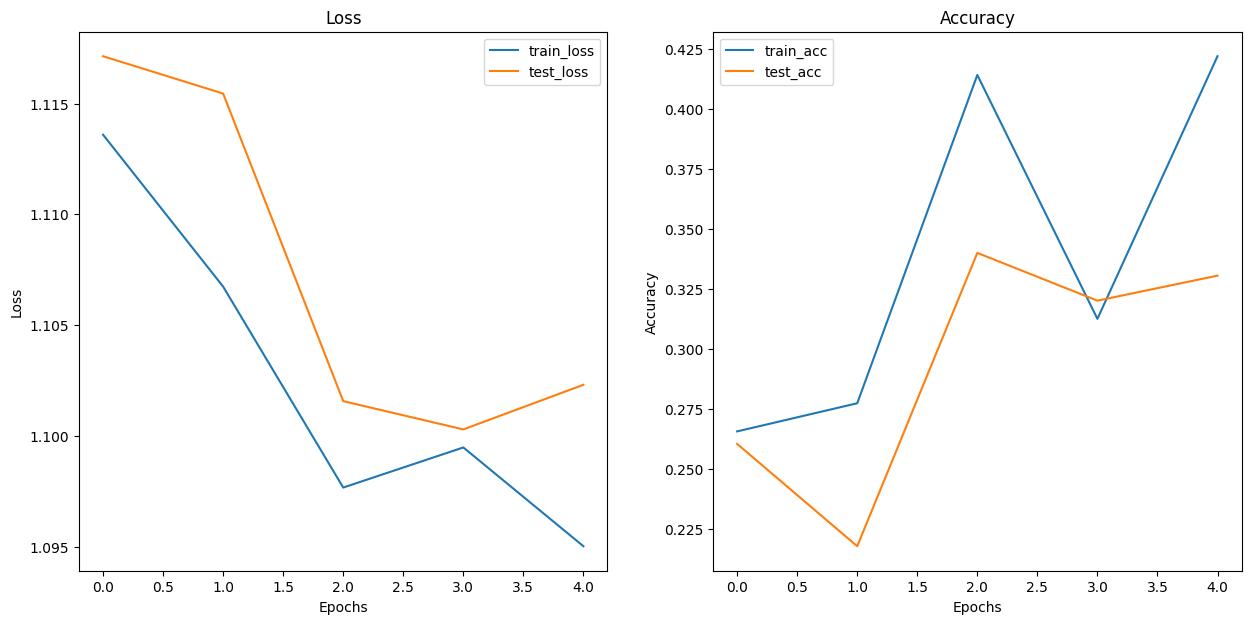

In [ ]:
plot_loss_curves(results_model1)

10. Compare model results

In [ ]:
import pandas as pd

model0_df = pd.DataFrame(results_model0)
model1_df = pd.DataFrame(results_model1)

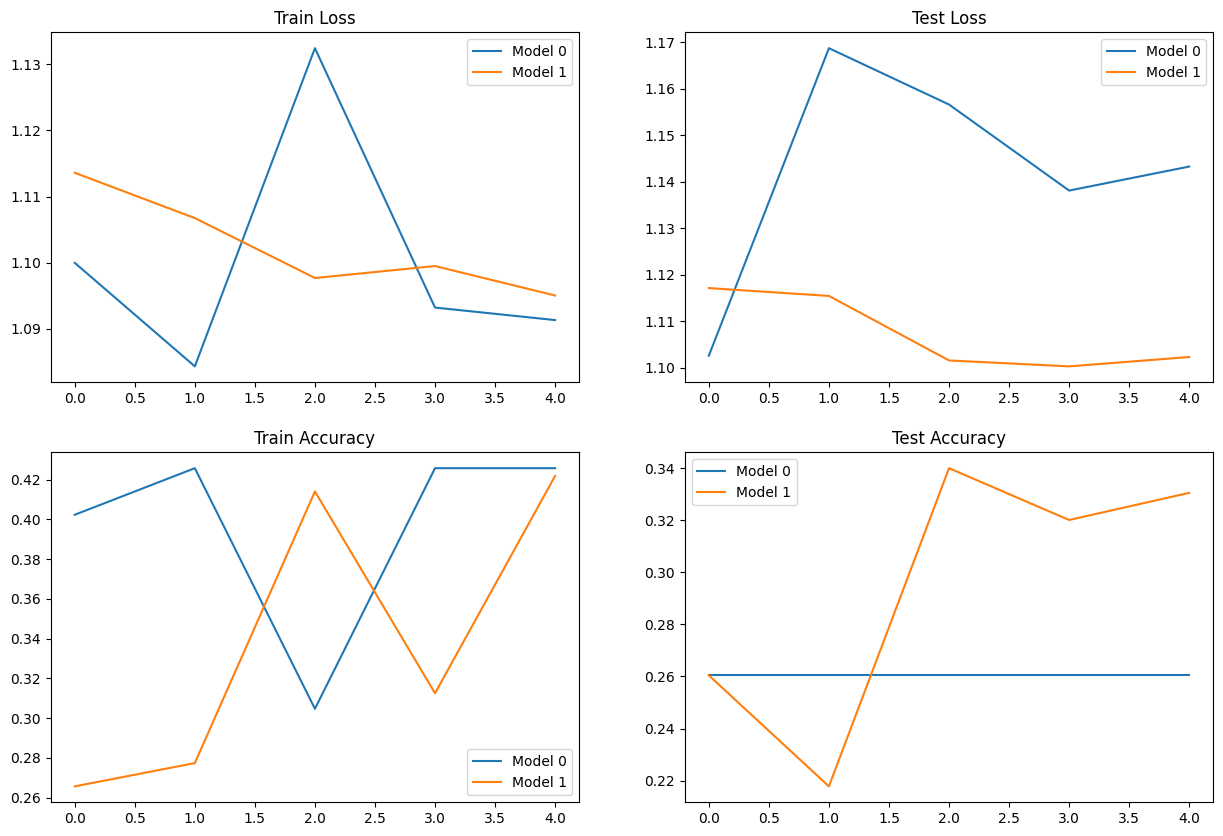

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(model0_df['train_loss'], label='Model 0')
plt.plot(model1_df['train_loss'], label='Model 1')
plt.legend()
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(model0_df['test_loss'], label='Model 0')
plt.plot(model1_df['test_loss'], label='Model 1')
plt.legend()
plt.title('Test Loss')

plt.subplot(2,2,3)
plt.plot(model0_df['train_acc'], label='Model 0')
plt.plot(model1_df['train_acc'], label='Model 1')
plt.legend()
plt.title('Train Accuracy')

plt.subplot(2,2,4)
plt.plot(model0_df['test_acc'], label='Model 0')
plt.plot(model1_df['test_acc'], label='Model 1')
plt.legend()
plt.title('Test Accuracy')

plt.show()

# 11. Make a prediction on a custom image

In [ ]:
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

11.1 Loading in a custom image with PyTorch

In [ ]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

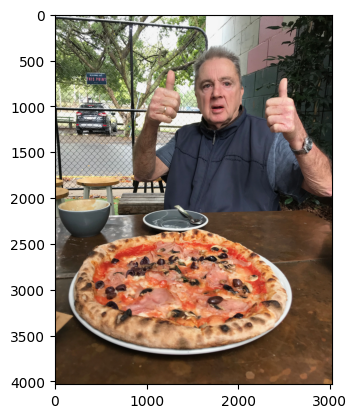

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.show()

In [ ]:
# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

# 11.2 Predicting on custom images with a trained PyTorch model

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_tensor = custom_image_uint8.unsqueeze(dim=0)
    custom_image_pred = model_1(custom_image_tensor.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_tensor = custom_image.unsqueeze(dim=0)
    custom_image_pred = model_1(custom_image_tensor.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7620480 and 2560x3)

In [ ]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [ ]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [ ]:
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_transformed_tensor = custom_image_transformed.unsqueeze(dim=0)
    custom_image_transformed_pred = model_1(custom_image_transformed_tensor.to(device))

In [ ]:
class_names[custom_image_transformed_pred.argmax()]

'pizza'

# 11.3 Putting custom image prediction together: building a function

In [ ]:
def predict_image(img_path, model):
    custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0

    custom_image_transformed = custom_image_transform(custom_image)
    model.eval()
    with torch.inference_mode():
        custom_image_transformed_tensor = custom_image_transformed.unsqueeze(dim=0)
        custom_image_transformed_pred = model(custom_image_transformed_tensor.to(device))

    return class_names[custom_image_transformed_pred.argmax()]

In [ ]:
predict_image(custom_image_path, model_1)

'pizza'